# CS 109B - Course Project - Team 14
## Deep Learning - Posters

## 1. Prepare AWS

#### Install packages

In [143]:
# import pip
# def install(package):
#     pip.main(['install', package])
# install('boto')
# install('opencv-python')
# install('h5py')
# # # # install('scikit-image')

#### Retrieve images and data from Amazon's S3

In [144]:
# import boto
# import boto.s3.connection
# access_key = 'my_access_key'
# secret_key = 'my_secret_key'

# conn = boto.connect_s3(
#         aws_access_key_id = access_key,
#         aws_secret_access_key = secret_key,
#         host = 's3.amazonaws.com',
#         #is_secure = False,               # uncomment if you are not using ssl
#         calling_format = boto.s3.connection.OrdinaryCallingFormat(),
#         )

# bucket = conn.get_bucket('cs109b.dkm.posters.250sq')
# key = bucket.get_key('Posters_250_250.zip')
# key.get_contents_to_filename('Posters_250_250.zip')

# bucket = conn.get_bucket('cs109b.dkm.imdb.data')
# key = bucket.get_key('imdb_movies_trim.csv')
# key.get_contents_to_filename('imdb_movies_trim.csv')

# import os, zipfile
# home_dir = os.path.expanduser("~")
# os.chdir(home_dir)
# my_zipfile = zipfile.ZipFile('Posters_250_250.zip')
# my_zipfile.extractall()

## 2. Load Data

#### Load packages and set display options

In [145]:
import numpy as np
import pandas as pd
import os

from __future__ import print_function
import cv2 
from scipy import ndimage, misc
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.metrics import hamming_loss

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, ZeroPadding2D
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display, HTML, Markdown
%matplotlib inline
plt.style.use('ggplot') 
def printmd(string):
    display(Markdown(string))

#### Set global constants

In [146]:
# input image dimensions
img_rows, img_cols = 128, 128

# smaller batch size means noisier gradient, but more updates per epoch
#Dom: keep high for laptop, lower for AWS
batch_size = 128

# 18 genres in our data set
num_classes = 19

# number of iterations over the complete training data
epochs = 150

#(80,75) equivilant to test 20 , train 60, validate 20
train_percent = 80
validation_percent = 75   #note: percentage of training not the entire set 

#### Load and clean Y data

In [147]:
movie_fields = ['imdb_id',
                'Action','Adventure','Animation','Comedy','Crime','Documentary','Drama',
                'Family','Fantasy','History','Horror','Music', 'Musical', 'Mystery',
                'Romance','Sci-Fi','Thriller','War','Western']
genres = movie_fields[1:]
small_genres = ['Western', 'Musical', 'Music', 'History', 'Animation', 'War', 'History', "Sci-Fi"]

#ignore ,'Game-Show','News','Reality-TV', 'Biography','Adult','Film-Noir'
df_im_0 = pd.read_csv( './imdb_movies_trim.csv',
                    encoding = 'utf-8',
                    usecols = movie_fields)

# filter out no-genre movies
df_im = df_im_0[df_im_0.iloc[:, 1:].any(axis = 1)] 

#reorder the columns
df_im = df_im[movie_fields]

#sort by movie id
df_im = df_im.sort_values(by = 'imdb_id')

# prep for augmentation
small_genres_idx = []
for i in xrange(len(small_genres)):
    small_genres_idx.append(movie_fields.index(small_genres[i]))

## 3. Load and Prepare Images

#### Load and resize images

In [148]:
images = []
imdb_ids = []
imdb_id_image_not_found = []

num_images = df_im.shape[0]
#num_images = 100
for i in xrange(num_images):
    
    # retrieve movie object from imdb
    imdb_id = int(df_im.iloc[i,0])
    filepath = './Posters_250_250/' + str(imdb_id).zfill(7) + '.jpg'

    # image found, so load, resize, and collect it
    if os.path.isfile(filepath) :

        image = cv2.imread(filepath)
        image = cv2.resize(image,(img_rows, img_cols))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # needed if loading images with scikit-image
        image = np.array(image).reshape((3, img_rows, img_cols))
        
        # add image and movie id to list
        images.append([image])
        imdb_ids.append(imdb_id)
        
        # image augmentation on minority genres
        if sum(df_im.iloc[i, small_genres_idx]) >= 1 :
            for i in range(10):
                image_flip = cv2.flip(image, 1) # vertical-axis flip
                images.append([image_flip])
                imdb_ids.append(imdb_id)
            
    else:
        # add id to failure list
        imdb_id_image_not_found.append(imdb_id)
        
# collect the image list into an array
x = np.array(images) 
x = x[:, 0, :, :]
images = None
df_imdb_ids = pd.DataFrame({'id': imdb_ids })

print()
print ('images loaded', len(imdb_ids))
print ('images failed', len(imdb_id_image_not_found))


images loaded 129059
images failed 8


#### Split into test and train data sets

In [149]:
#Build y taking care to align rows with x
#merge ensures that if images were not found they do not cause a mis-aslignment of x and y
y = pd.merge(left = df_imdb_ids , right = df_im , left_on = 'id', right_on = 'imdb_id')

#drop first two columns (id and imdb_id) leaving just the 18 encoded genres
y = y.ix[:,2:]

#split y into test and train
y_train, y_test = sk_split(y, train_size = train_percent / 100.0)

#take out a portion for validation from the training set
y_train, y_valid = sk_split(y_train, train_size = validation_percent / 100.0)

#use post split indicies from y to split x into the same groups
x_test   = x[y_test.index]
x_train  = x[y_train.index]
x_valid  = x[y_valid.index]

#convert label dataframes to numpy arrays
y_train = y_train.values
y_test  = y_test.values
y_valid = y_valid.values

print()
print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:' , x_test.shape)
print()
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:' , y_test.shape)


#free up memory
x = y = None


x_train shape: (77435, 3, 128, 128)
x_valid shape: (25812, 3, 128, 128)
x_test shape: (25812, 3, 128, 128)

y_train shape: (77435, 19)
y_valid shape: (25812, 19)
y_test shape: (25812, 19)


#### Using tensorflow as backend so expect order of array as is (n = sample size, img_rows, img_cols, colour = 3)

In [150]:
if K.image_data_format() ==  'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    x_valid = x_valid.reshape(x_valid.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

#### Centre and normalise images

In [151]:
# normalize image values to [0,1] (Keras sample code doesn't center)
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_valid /= 255
x_test /= 255

print()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (77435, 128, 128, 3)
77435 train samples
25812 test samples


## 4. Train Model

#### Create dictionary of class weights

In [152]:
# create dictionary of class weights
class_count = y_train.sum(axis = 0) + 1
class_weight = y_train.shape[0] / (num_classes * class_count)
class_weight_dict = dict(zip(np.arange(num_classes), class_weight))

#### Create model shell

In [153]:
# create an empty network model
model = Sequential()
model.add(Dropout(0.2, input_shape = input_shape))

# --- input layer ---
model.add(Conv2D(64, kernel_size = (5, 5), activation = 'relu'))
model.add(Conv2D(64, kernel_size = (5, 5), activation = 'relu'))
model.add(Conv2D(64, kernel_size = (5, 5), activation = 'relu'))

# --- max pool ---
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# --- next layer ---
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))

# --- max pool ---
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# flatten for fully connected classification layer
model.add(Flatten())

# --- fully connected layer ---
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))

# --- classification ---
model.add(Dense(num_classes, activation = 'sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_26 (Dropout)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 124, 124, 64)      4864      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 120, 120, 64)      102464    
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 116, 116, 64)      102464    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 58, 58, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 56, 56, 128)       73856     
__________

#### Compile model

In [154]:
# use basic categorical crossentropy with stochastic gradient decent
# evaluate model in terms of accuracy
# lr : learning rate (start from 0.1 and move as low as 10^-6)
# momentum: start with .5 and tune to .9

sgd = SGD(lr = 0.1, momentum = 0.9, nesterov = True)
# adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
model.compile(loss = 'binary_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

#### Train model and score with validation data

In [155]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                              patience = 10, min_lr = 0.000001)

early_stop = EarlyStopping (monitor = 'val_loss', min_delta = .0001, patience = 15, verbose = 0, mode = 'auto')

csv_logger = CSVLogger('training.log')

model_checkpoint = ModelCheckpoint(filepath = "./best_model.hdf5", monitor = 'val_loss', 
                                   verbose = 0, save_best_only = True, 
                                   save_weights_only = False, mode = 'auto', period = 1)

history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = [reduce_lr, early_stop, csv_logger, model_checkpoint],
                    verbose = 1,
                    validation_data = (x_valid, y_valid),
                    class_weight = class_weight_dict)

Train on 77435 samples, validate on 25812 samples
Epoch 1/150
77435/77435 [==============================] - 1052s - loss: 0.1248 - acc: 0.8449 - val_loss: 0.3953 - val_acc: 0.8483

## 5. Score Model

In [156]:
### prepare metrics calculations

avg_tags_per_movie = y_train.sum(axis = 1).mean()
y_test_predict_proba = model.predict(x_test, verbose = 0)

threshold_accus = np.zeros(101)
tp_rate = np.zeros(101)
fp_rate = np.zeros(101)
hamming_losses = np.zeros(101)

for i in range(101):
    y_test_predict = y_test_predict_proba > i / 100.0
    threshold_accus[i] = (y_test == y_test_predict).sum() / float((num_classes * y_test.shape[0]))
    tp_rate[i] = ((y_test == 1) & (y_test_predict == 1)).sum() / float((num_classes * y_test.shape[0]))
    fp_rate[i] = ((y_test == 0) & (y_test_predict == 1)).sum() / float((num_classes * y_test.shape[0]))
    hamming_losses[i] = hamming_loss(y_test, y_test_predict)
    
opt_hamming_threshold = hamming_losses.argmin() / 100.0

In [157]:
# score after training
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', round(score[0], 4))
print('Test accuracy:', round(score[1], 4))

Test loss: 0.1555
Test accuracy: 0.9565


In [158]:
y_test_predict = y_test_predict_proba > .5
test_accu = (y_test == y_test_predict).sum() / float((num_classes * y_test.shape[0]))
print('Test accuracy using probability threshold of 0.50 :', round(test_accu, 4))

Test accuracy using probability threshold of 0.50 : 0.9565


In [159]:
y_test_predict = y_test_predict_proba > opt_hamming_threshold
test_accu = (y_test == y_test_predict).sum() / float((num_classes * y_test.shape[0]))
print('Test accuracy using probability threshold of', round(opt_hamming_threshold, 2), ':', round(test_accu, 4))

Test accuracy using probability threshold of 0.73 : 0.9585


In [160]:
y_test_predict = np.zeros([y_test.shape[0], num_classes])
test_accu = (y_test == y_test_predict).sum() / float((num_classes * y_test.shape[0]))
print('Test accuracy using classifier that always predicts 0 :', round(test_accu, 4))

Test accuracy using classifier that always predicts 0 : 0.8482


In [161]:
y_test_predict = y_test_predict_proba > opt_hamming_threshold
temp = pd.DataFrame(y_test_predict.sum(axis = 0), columns = ['Count'])
temp.index = genres
temp

,Count
Action,3932
Adventure,3509
Animation,3037
Comedy,4879
Crime,1067
Documentary,1920
Drama,11378
Family,2344
Fantasy,2083
History,2968


In [162]:
from sklearn.metrics import precision_score as ps

y_test_predict = y_test_predict_proba > opt_hamming_threshold
avg_precision = ps(y_test, y_test_predict, average = 'samples')
print('Average test precision (samples):', round(avg_precision, 4))

Average test precision (samples): 0.8017


In [163]:
from sklearn.metrics import recall_score as rs

y_test_predict = y_test_predict_proba > opt_hamming_threshold
avg_recall = rs(y_test, y_test_predict, average = 'samples')
print('Average test recall (samples):', round(avg_recall, 4))

Average test recall (samples): 0.7413


/usr/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [164]:
y_test_predict_top_class = np.argmax(y_test_predict_proba, axis = 1)
test_top_class_accu_list = [(y_test[i, y_test_predict_top_class[i]] == 1) for i in range(y_test.shape[0])]
test_top_class_accu = np.sum(test_top_class_accu_list) / float(y_test.shape[0])
print('Test accuracy matching top class:', round(test_top_class_accu, 4))

Test accuracy matching top class: 0.8403


In [165]:
y_test_predict = y_test_predict_proba > 0.33
test_hamming_loss = hamming_loss(y_test, y_test_predict)
print('Test Hamming loss:', round(test_hamming_loss, 4))

Test Hamming loss: 0.0478


## 6. Visualization

### Training process

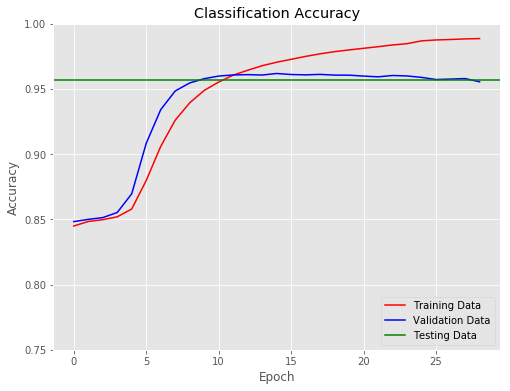

In [170]:
### plot training process
print()
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(history.history['acc'], color = 'red', label = 'Training Data')
ax.plot(history.history['val_acc'], color = 'blue', label = 'Validation Data')
ax.axhline(y = score[1], color = 'green', label = 'Testing Data')
ax.set_ylim(0.75, 1)
ax.legend(loc = 'lower right')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Classification Accuracy")

plt.show()

### ROC Curve

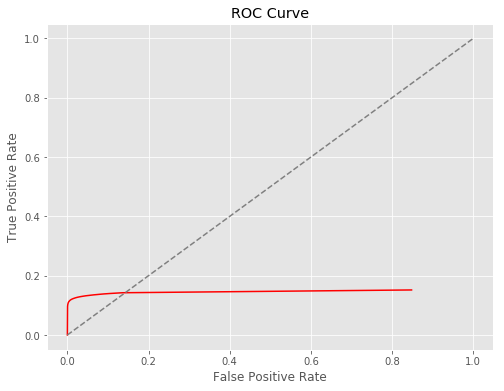

In [167]:
### ROC curve
print()
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(fp_rate, tp_rate, color = 'red')
ax.plot((0, 1), (0, 1), linestyle = 'dashed', color = 'gray')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")

plt.show()

## Features Learned

#### Layer 1

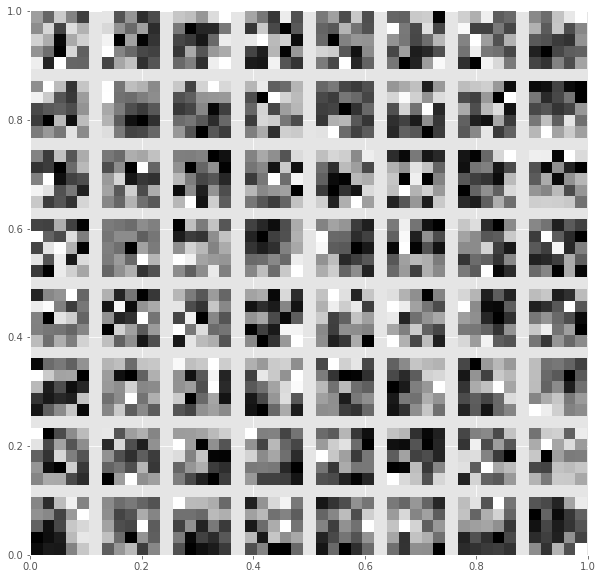

In [208]:
# get layer weights
layer = model.layers[1]
weights = layer.get_weights()

# set up plot
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)

# populate plot
index = 0
for i in range(8):
    for j in range(8):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        index += 1
        ax = fig.add_subplot(8,8,index)
        ax.axis('off')
        plt.imshow(w, cmap = 'gray')    

# show plot
plt.show()

#### Layer 6

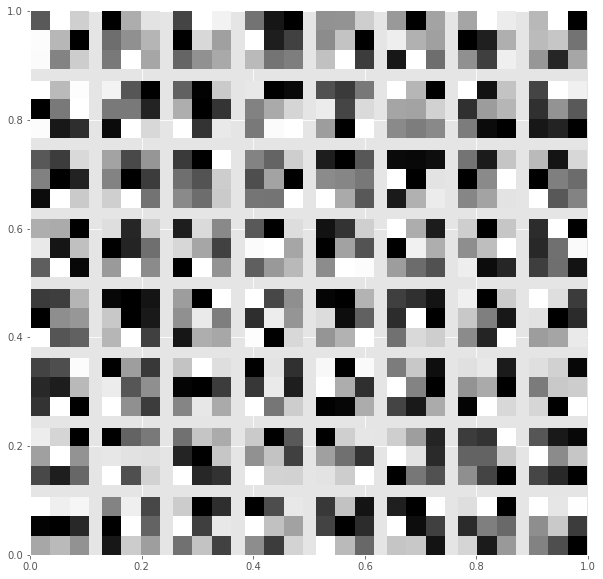

In [209]:
# get layer weights
layer = model.layers[6]
weights = layer.get_weights()

# set up plot
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)

# populate plot
index = 0
for i in range(8):
    for j in range(8):
        w = weights[0][:,:,0,index]
        w = w.reshape(3,3)
        index += 1
        ax = fig.add_subplot(8,8,index)
        ax.axis('off')
        plt.imshow(w, cmap = 'gray')    

# show plot
plt.show()

#### Layer 8

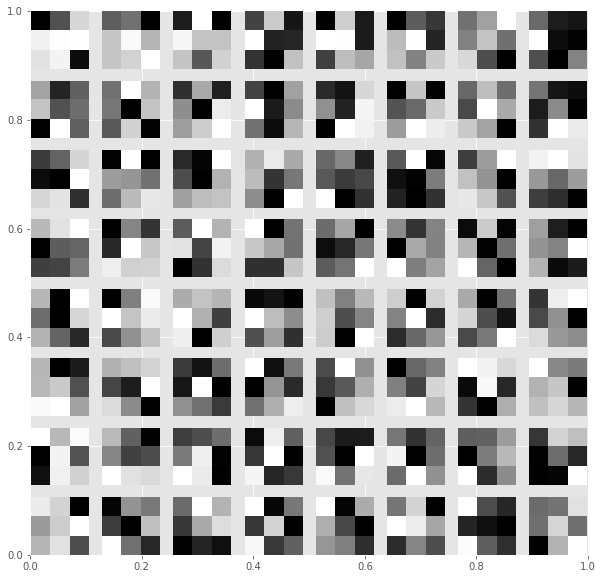

In [207]:
# get layer weights
layer = model.layers[8]
weights = layer.get_weights()

# set up plot
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)

# populate plot
index = 0
for i in range(8):
    for j in range(8):
        w = weights[0][:,:,0,index]
        w = w.reshape(3,3)
        index += 1
        ax = fig.add_subplot(8,8,index)
        ax.axis('off')
        plt.imshow(w, cmap = 'gray')    

# show plot
plt.show()